# Accessing and Processing the Optical Absorption and Attenuation (OPTAA) Data from the Coastal Surface Piercing Profiler (CSPP)

This example uses data from the [OOI Gold Copy THREDDS catalog](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/catalog.html) to demonstrate the steps a user would use to access and process the [Sea-Bird Scientific AC-S](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) (known as the OPTAA in OOI-speak) from one of the [coastal surface-piercing profilers (CSPP)](https://oceanobservatories.org/marine-technologies/profilers/) employed by the [OOI Coastal Endurance Array](https://oceanobservatories.org/array/coastal-endurance/). 

The benefit to using the Gold Copy THREDDS catalog, as opposed to the OOI M2M system is the speed of access to the data. In the M2M system, each and every user request for the data requires the system to collect, process and format the data prior to delivery. For complex data, or data that requires extensive processing, this time can be quite lengthy. With the Gold Copy THREDDS catalog, those requests have already been done for you and you can just start with downloading the data.

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import load_gc_thredds
from pyseas.data.opt_functions import opt_internal_temp, opt_external_temp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

For this example, we'll look at the data from Deployment 15 of the Oregon Shelf Coastal Surface-Piercing Profiler (CSPP) using data from the OOI Gold Copy THREDDS catalog rather than requesting the data from OOINet. The user still needs to know some needed parameters to find the data, such as the site, node, sensor, method and stream name prior to downloading the data. With that knowledge the `load_gc_thredds` function can be used (with an optional regex tag) to download the data.

In [2]:
# Setup needed parameters for the request
site = 'CE02SHSP'           # OOI site designator
node = 'SP001'              # OOI node designator
sensor = '04-OPTAAJ000'     # OOI sensor designator
method = 'recovered_cspp'   # OOI data delivery method
stream = 'optaa_dj_cspp_instrument_recovered'  # OOI stream name
tag = '.*deployment0015.*OPTAA.*\\.nc$'  # limit request to OPTAA NetCDF files from Deployment 15

# request the data from the OOI M2M API ...
data = load_gc_thredds(site, node, sensor, method, stream, tag)

The OPTAA data requires some clean-up and re-processing before a user should start working with it. We'll start with some basic clean-up and then proceed to some more advanced re-processing.

In [3]:
# Do some basic clean-up of the data prior to further work

# drop some of the variables:
#   internal_timestamp == time, redundant so can remove
#   profiler_timestamp == internal_timestamp == time, redundant so can remove
#   suspect_timestamp = not used, meaning of variable uncertain
#   pressure_counts = no OOI OPTAA's have a pressure sensor, all 0's so can remove
data = data.drop(['internal_timestamp', 'profiler_timestamp', 'suspect_timestamp', 'pressure_counts'])

# rename some of the variables so it is bit clearer where they came from
#   sea_water_practical_salinity => ctd_salinity, interpolated in from co-located CTD
#   sea_water_temperature => ctd_temperature, interpolated in from co-located CTD
#   int_ctd_pressure => ctd_pressure, interpolated in from co-located CTD
rename = {
    'sea_water_temperature': 'ctd_temperature',
    'sea_water_practical_salinity': 'ctd_salinity',
    'int_ctd_pressure': 'ctd_pressure'
}
data = data.rename(rename)

# add the original variable name as an attribute, if renamed
for key, value in rename.items():
    data[value].attrs['ooinet_variable_name'] = key

data

<xarray.Dataset>
Dimensions:                  (time: 55904, wavelength: 85)
Coordinates:
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 80 81 82 83 84
  * time                     (time) datetime64[ns] 2019-08-13T19:03:52.890000...
Data variables: (12/23)
    external_temp_raw        (time) uint16 41014 41015 41013 ... 38599 38592
    c_signal_counts          (time, wavelength) uint16 690 810 948 ... 3393 3012
    deployment               (time) int32 15 15 15 15 15 15 ... 15 15 15 15 15
    a_signal_counts          (time, wavelength) uint16 545 649 767 ... 7368 6568
    lat                      (time) float64 44.64 44.64 44.64 ... 44.64 44.64
    ctd_pressure             (time) float64 76.29 76.29 76.28 ... 0.823 0.7473
    ...                       ...
    c_signal_dark_counts     (time) uint16 720 720 721 721 ... 720 720 720 720
    a_signal_dark_counts     (time) uint16 625 625 625 625 ... 645 645 645 645
    c_reference_counts       (time, wavelength) uint16 863 994 ... 8778 8197
    a_reference_dark_counts  (time) uint16 472 472 472 472 ... 472 472 473 473
    depth                    (time) float64 75.66 75.66 75.65 ... 0.8163 0.7412
    ctd_temperature          (time) float64 7.72 7.72 7.719 ... 12.11 12.1 12.1
Attributes: (12/67)
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

The OOI OPTAA data sets do not include data products from the intermediary optical absorption and beam attenuation processing steps, where:

- the data has been converted from the raw, but has not been corrected for the effects of temperature and salinity 
- the data has been has been corrected for the effects of temperature and salinity
- the optical absorption data has been corrected for effects of scattering

It is considered good practice to make these intermediate data products available to users, especially more advanced users wishing to assess different methods for the scatter corrections. 

I've provide example code here that would allow a user to recalculate these intermediate products starting from the raw measurements. Additionally, I've switched the scattering correction used by OOI to the simpler [Baseline Correction](https://ioccg.org/wp-content/uploads/2020/09/absorption_protocol_final-incl-cover_rev.pdf) method rather than the more complicated [modified proportional method](https://github.com/cwingard/ion-functions/blob/master/ion_functions/data/opt_functions.py#L508) employed by OOI. Both resulting temperature, salinity and scatter corrected data products are then available for users to compare if so desired.

In order to create these intermediate data products, we first need to download the calibration data for the instrument from the OOI Asset Management records hosted on GitHub.

In [4]:
# Pull the calibration coefficients from the GitHub hosted Asset Management system.
from cgsn_processing.process.finding_calibrations import find_calibration
from cgsn_processing.process.proc_optaa import Calibrations

# load the instrument calibration data
coeff_file = 'ce02shsp.optaa.deploy15.cal_coeffs.json'
dev = Calibrations(coeff_file)  # initialize calibration class

# check for the source of calibration coeffs and load accordingly
if os.path.isfile(coeff_file):
    # we always want to use this file if it already exists
    dev.load_coeffs()
else:
    # load from the CI hosted CSV files
    csv_url = find_calibration('OPTAA', data.attrs['SerialNumber'][4:], 
                               data['time'][0].values.astype(float) / 10**9)
    if csv_url:
        tca_url = re.sub('.csv', '__CC_taarray.ext', csv_url)
        tcc_url = re.sub('.csv', '__CC_tcarray.ext', csv_url)
        dev.read_devurls(csv_url, tca_url, tcc_url)

        # determine the grating index -- NOTE, THIS ONLY APPLIES TO THIS SPECIFIC INSTANCE,
        # STILL WORKING TO CREATE A GENERIC MEANS OF DETERMINATION FOR ALL AC-S INSTRUMENTS
        awlngths = dev.coeffs['a_wavelengths']
        awlngths[(awlngths < 545) | (awlngths > 605)] = np.nan
        cwlngths = dev.coeffs['c_wavelengths']
        cwlngths[(cwlngths < 545) | (cwlngths > 605)] = np.nan
        grate_index = np.nanargmin(np.diff(awlngths) + np.diff(cwlngths))
        dev.coeffs['grate_index'] = grate_index

# check the device file coefficients against the data file contents
if dev.coeffs['serial_number'] != int(data.attrs['SerialNumber'][4:]):
    raise Exception('Serial Number mismatch between ac-s data and the device file.')
elif dev.coeffs['num_wavelengths'] != data['num_wavelengths'][0]:
    raise Exception('Number of wavelengths mismatch between ac-s data and the device file.')
else:
    dev.save_coeffs()

dev.coeffs

{'temp_calibration': 23.5,
 'a_wavelengths': array([401.2, 405. , 408.7, 411.9, 415.3, 419.2, 423.3, 427.4, 431.5,
        435.4, 438.9, 443.2, 447.8, 452. , 456.4, 460.4, 464.5, 468.5,
        473.3, 477.8, 482.4, 486.7, 490.9, 494.9, 499.1, 503.5, 508. ,
        512.3, 517. , 521.3, 525.6, 529.8, 533.5, 537.7, 541.6, 545.7,
        549.7, 553.6, 557.9, 561.8, 565.9, 569.6, 573. , 576.4, 579.3,
        583. , 586.9, 591. , 594.9, 599.1, 603.3, 607.5, 611.8, 616.2,
        620.2, 624.5, 628.7, 632.7, 636.7, 640.8, 644.8, 648.9, 653.2,
        657.7, 661.9, 666.2, 670.5, 674.5, 678.5, 682.5, 686.4, 690.3,
        693.9, 697.6, 701.2, 704.9, 708.4, 712.1, 715.7, 719.3, 722.7,
        725.9, 729.5, 732.6, 735.8]),
 'a_offsets': array([-1.118704, -0.95062 , -0.799257, -0.662528, -0.537118, -0.420091,
        -0.313261, -0.209484, -0.114756, -0.02481 ,  0.058958,  0.139318,
         0.215207,  0.287463,  0.357251,  0.424577,  0.488015,  0.548444,
         0.605475,  0.659976,  0.712679,  0.

With those calibration coefficients in hand, the following functions can be used to recalculate the intermediate data products

In [5]:
# Recalculate the absorption and attenuation data products from the raw data to provide the 
# intermediate data products between the final absorption and beam_attenuation. These functions
# are available in the cgsn_processing package (some of the variable names are different, so 
# differences would need to be accounted for), and are reproduced here to provide better insight
# into the exact sequence of processing to go from raw OPTAA data to a final temperature, 
# salinity and scatter corrected data products.
from scipy.interpolate import CubicSpline
from pyseas.data.opt_functions import opt_internal_temp, opt_external_temp
from pyseas.data.opt_functions_tscor import tscor


def pd_calc(ref, sig, offset, tintrn, tbins, tarray):
    """
    Convert the raw reference and signal measurements to scientific units. Uses
    a simplified version of the opt_pd_calc function from the pyseas library (
    fork of the OOI ion_functions code converted to Python 3) to take advantage
    of numpy arrays and the ability to "vectorize" some of the calculations.

    :param ref: raw reference light measurements (OPTCREF_L0 or OPTAREF_L0, as
        appropriate) [counts]
    :param sig: raw signal light measurements (OPTCSIG_L0 or OPTASIG_L0, as
            appropriate) [counts]
    :param offset: 'a' or 'c' (as appropriate) clear water offsets from the
        AC-S device file [m-1]
    :param tintrn: internal instrument temperature [deg_C]
    :param tbins: instrument specific internal temperature calibration bin
        values from AC-S device file [deg_C]
    :param tarray: instrument, wavelength and channel ('c' or 'a') specific
        internal temperature calibration correction coefficients from AC-S
        device file [m-1]
    :return: uncorrected beam attenuation/optical absorption coefficients [m-1]
    """
    # create a linear temperature correction factor based on the internal instrument temperature
    temp_corr = sig * np.nan
    for i, degC in enumerate(tintrn.values):
        # find the indexes in the temperature bins corresponding to the values bracketing the internal temperature.
        ind1 = np.nonzero(tbins - degC < 0)[0][-1]
        ind2 = np.nonzero(degC - tbins < 0)[0][0]
        t0 = tbins[ind1]  # set first bracketing temperature
        t1 = tbins[ind2]  # set second bracketing temperature

        # Calculate the linear temperature correction.
        dt0 = tarray[:, ind1]
        dt1 = tarray[:, ind2]
        temp_corr[i, :] = dt0 + ((degC - t0) / (t1 - t0)) * (dt1 - dt0)

    # Calculate the uncorrected signal [m-1]; the pathlength is 0.25m.
    # Apply the corrections for the clean water offsets (offset) and
    # the instrument's internal temperature (deltaT).
    pd = (offset - (1. / 0.25) * np.log(sig / ref)) - temp_corr
    return pd


def holo_grater(wlngths, spectra, index):
    """
    Derived from the Matlab HoloGrater function in Jesse Bausell's 
    acsPROCESS_INTERACTIVE toolbox (link below) used in preparing 
    AC-S data for NASA's SeaBASS submission process. From the 
    original source:

    "This function performs the holographic grating correction for raw
    ac-s spectra. For each individual spectrum it calculates expected
    absorption/attenuation at the lowest wavelength of the second grating
    (upper wavelengths) using matlab's spline function. It then subtracts
    this value from the observed absorption/attenuation creating an offset."
    
    This function utilizes the SciPy CubicSpline function to accomplish the
    same correction.
    
    For original code see https://github.com/JesseBausell/acsPROCESS_INTERACTIVE
    """    
    # Interpolate between holographic gratings and calculate the offset
    spl = CubicSpline(wlngths[index-2:index+1], spectra[index-2:index+1])
    interpolation = spl(wlngths[index+1], extrapolate=True)
    
    # calculate the offset as the difference between the observed and expected absorption/attenuation
    offset = interpolation - spectra[index+1]

    # use the offset to correct the second holographic grating
    spectra[index+1:] = spectra[index+1:] + offset
    
    return spectra, offset


def apply_dev(optaa, coeffs):
    """
    Processes the raw data contained in the optaa dictionary and applies the 
    factory calibration coefficents contained in the coeffs dictionary to
    convert the data into initial science units.

    :param optaa: xarray dataset with the raw absorption and beam attenuation
        measurements.
    :param coeffs: Factory calibration coefficients in a dictionary structure

    :return optaa: xarray dataset with the raw absorption and beam attenuation
        measurements converted into particulate and beam attenuation values
        with the factory pure water calibration values subtracted.
    """
    # convert internal and external temperature sensors
    optaa['internal_temp'] = opt_internal_temp(optaa['internal_temp_raw'])
    optaa['external_temp'] = opt_external_temp(optaa['external_temp_raw'])

    # calculate the L1 OPTAA data products (uncorrected beam attenuation and absorbance) for particulate
    # and dissolved organic matter with pure water removed.
    apd = pd_calc(optaa['a_reference_counts'], optaa['a_signal_counts'], coeffs['a_offsets'], 
                  optaa['internal_temp'], coeffs['temp_bins'], coeffs['ta_array'])
    cpd = pd_calc(optaa['c_reference_counts'], optaa['c_signal_counts'], coeffs['c_offsets'], 
                  optaa['internal_temp'], coeffs['temp_bins'], coeffs['tc_array'])
    
    # correct the spectral "jump" often observed between the two halves of the linear variable filter
    nrows = apd.shape[0]
    offsets = np.ones([nrows, 2]) * np.nan
    if coeffs['grate_index']:
        for i in range(nrows):
            apd[i, ~np.isfinite(apd[i, :])] = np.nan
            cpd[i, ~np.isfinite(cpd[i, :])] = np.nan
            try:
                apd[i, :], offsets[i, 0] = holo_grater(coeffs['a_wavelengths'], apd[i, :], coeffs['grate_index'])
            except ValueError:
                # if the spectra is badly malformed (can happen with bubbles or other fouling), we can
                # get NaN's or Inf's in the spectra. If this happens, NaN out the whole spectra
                apd[i, :] = apd[i, :] * np.nan
            
            try:
                cpd[i, :], offsets[i, 1] = holo_grater(coeffs['c_wavelengths'], cpd[i, :], coeffs['grate_index'])
            except:
                # if the spectra is badly malformed (can happen with bubbles or other fouling), we can
                # get NaN's or Inf's in the spectra. If this happens, NaN out the whole spectra
                cpd[i, :] = cpd[i, :] * np.nan

    # put it all back together, adding the jump offsets
    optaa['apd'] = apd
    optaa['cpd'] = cpd
    optaa['a_jump_offsets'] = ('time', offsets[:, 0])
    optaa['c_jump_offsets'] = ('time', offsets[:, 1])

    # return the optaa dictionary with the factory calibrations applied and the spectral jump between
    # linear variable filter halves corrected
    return optaa


def tempsal_corr(channel, pd, wlngth, tcal, degC, salinity):
    """
    Apply temperature and salinity corrections to the converted absorption
    and attenuation data. Uses a simplified version of the opt_pd_calc
    function from the pyseas library (fork of the OOI ion_functions code
    converted to Python 3) to take advantage of numpy arrays and the 
    ability to "vectorize" some of the calculations.

    :param channel: string ('a' or 'c') indicating either the absorption or
        attenuation channel is being corrected
    :param pd: array of converted absorption or attenuation data
    :param wlngth: absorption or attenuation channel wavelengths from the
        calibration coefficients
    :param tcal: temperature of the pure water used in the calibrations
    :param degC: in-situ temperature, ideally from a co-located CTD
    :param salinity: in-situ salinity, ideally from a co-located CTD
    :return: temperature and salinity corrected data
    """
    # create the temperature and salinity correction arrays for each wavelength
    cor_coeffs = np.array([tscor[ii] for ii in wlngth])
    nrows = len(degC)

    temp_corr = np.tile(cor_coeffs[:, 0], [nrows, 1])
    saln_c_corr = np.tile(cor_coeffs[:, 1], [nrows, 1])
    saln_a_corr = np.tile(cor_coeffs[:, 2], [nrows, 1])

    delta_temp = np.atleast_2d(degC - tcal).T
    salinity = np.atleast_2d(salinity).T

    if channel == 'a':
        pd_ts = pd - delta_temp * temp_corr - salinity * saln_a_corr
    elif channel == 'c':
        pd_ts = pd - delta_temp * temp_corr - salinity * saln_c_corr
    else:
        raise ValueError('Channel must be either "a" or "c"')

    return pd_ts


def apply_tscorr(optaa, coeffs, temp, salinity):
    """
    Corrects the absorption and beam attenuation data for the absorption
    of seawater as a function of the seawater temperature and salinity (the
    calibration blanking offsets are determined using pure water.)
    
    If inputs temp or salinity are not supplied as calling arguments, then the 
    following default values are used.
        
        temp: temperature values recorded by the ac-s's external thermistor.
        salinity: 33.0 psu

    Otherwise, each of the arguments for temp and salinity should be either a 
    scalar, or a 1D array or a row or column vector with the same number of time
    points as 'a' and 'c'.

    :param optaa: xarray dataset with the temperature and salinity corrected
        absorbance data array that will be corrected for the effects of
        scattering.
    :param coeffs: Factory calibration coefficients in a dictionary structure
    :param temp: In-situ seawater temperature, ideally from a co-located CTD
    :param salinity: In-situ seawater salinity, ideally from a co-located CTD

    :return optaa: xarray dataset with the temperature and salinity corrected
        absorbance and attenuation data arrays added.
    """
    # apply the temperature and salinity corrections
    optaa['apd_ts'] = tempsal_corr('a', optaa['apd'], coeffs['a_wavelengths'], coeffs['temp_calibration'], 
                                   temp, salinity)
    optaa['cpd_ts'] = tempsal_corr('c', optaa['cpd'], coeffs['c_wavelengths'], coeffs['temp_calibration'], 
                                   temp, salinity)

    return optaa


def apply_scatcorr(optaa, coeffs):
    """
    Correct the absorbance data for scattering using Method 1, with the
    wavelength closest to 715 nm used as the reference wavelength for the
    scattering correction.

    :param optaa: xarray dataset with the temperature and salinity corrected
        absorbance data array that will be corrected for the effects of
        scattering.
    :param coeffs: Factory calibration coefficients in a dictionary structure

    :return optaa: xarray dataset with the method 1 scatter corrected
        absorbance data array added.
    """
    # find the closest wavelength to 715 nm
    reference_wavelength = 715.0
    idx = np.argmin(np.abs(coeffs['a_wavelengths'] - reference_wavelength))

    # use that wavelength as our scatter correction wavelength
    apd_ts = optaa['apd_ts']
    optaa['apd_ts_s'] = apd_ts - apd_ts[:, idx]

    return optaa


def estimate_chl_poc(optaa, coeffs):
    """
    Derive estimates of Chlorophyll-a and particulate organic carbon (POC)
    concentrations from the temperature, salinity and scatter corrected
    absorption and beam attenuation data.

    :param optaa: xarray dataset with the scatter corrected absorbance data.
    :param coeffs: Factory calibration coefficients in a dictionary structure

    :return optaa: xarray dataset with the estimates for chlorophyll and POC
        concentrations added.
    """
    # use the standard chlorophyll line height estimation with an extinction coefficient of 0.020.
    m676 = np.argmin(np.abs(coeffs['a_wavelengths'] - 676.0))
    m650 = np.argmin(np.abs(coeffs['a_wavelengths'] - 650.0))# find the closest wavelength to 715 nm
    reference_wavelength = 715.0
    idx = np.argmin(np.abs(coeffs['a_wavelengths'] - reference_wavelength))
    m715 = np.argmin(np.abs(coeffs['a_wavelengths'] - 715.0))
    apg = optaa['apd_ts_s']
    aphi = apg[:, m676] - 39/65 * apg[:, m650] - 26/65 * apg[:, m715]
    optaa['estimated_chlorophyll'] = aphi / 0.020

    # estimate the POC concentration from the attenuation at 660 nm
    m660 = np.argmin(np.abs(coeffs['c_wavelengths'] - 660.0))
    cpg = optaa['cpd_ts']
    optaa['estimated_poc'] = cpg[:, m660] * 380

    return optaa

The data needs some slight re-organization before we re-calculate the intermediate data products and so it can be used across deployments and sites. First, it needs to be split into profiles. For each profile, per the vendor recommendation, we want to drop the first 60 seconds worth of data (filter wheel spin-up and lamp warm-up), next we use a moving window filter to smooth out the spectral discontinuities common to the AC-S, then we bin the data into 25 cm depth bins using medians. With the data binned, the intermediate data products can be computed (binning also helps to reduce potential lags between the CTD and the OPTAA time records). Finally, once the profiles are identified and depth averaged, and the dataset is recombined, we need to make sure we have a consistent number of wavelengths (each OPTAA will have a different number of wavelengths), so we can combine multiple deployments together.

In [6]:
def process_profile(profile, coeffs):
    """
    For each profile, clean up the data by removing the first 60 seconds
    worth of data (per vendor recommendation), bin the data into 25 cm
    depth bins, calculate the intermediate data products and then re-organize
    the structure of the 2D variables to allow for concatenation of the 
    profiles across deployments
    """
    # drop the first 60 seconds worth of data
    profile = profile.where(profile.on_seconds > 60, drop=True)
    
    # apply the device file, the temperature and the temperature and salinity corrections
    profile = apply_dev(profile, coeffs)
    profile = apply_tscorr(profile, coeffs, profile.ctd_temperature, profile.ctd_salinity)

    # smooth the data to help minimize some of the noisiness common to bio-optical sensors
    smth = profile.rolling(time=5, center=True).median().dropna("time")  # ~1.25 second median boxcar
    smth = smth.rolling(time=5, center=True).median().dropna("time")     # ~1.25 second median boxcar 
    
    # bin the data into 25 cm depth bins (center bins by using a 1/2 bin size offset)
    bins = smth.groupby_bins('depth', np.arange(0.125, 75.125, 0.25))    
    
    # compute the median averages of the binned data. since we can't preserve 
    # the data set the way we want, we need to process each bin separately
    binned = []
    for grp in bins:
        avg = grp[1].median('time', keepdims=True, keep_attrs=True)            # median averages
        avg = avg.assign_coords({'time': np.atleast_1d(grp[1].time.mean().values)})  # add time back
        avg['wavelength_a'] = avg.wavelength_a.transpose()                     # swap dimension order 
        avg['wavelength_c'] = avg.wavelength_c.transpose()                     # swap dimension order 
        avg['depth'] = avg['depth'] * 0 + grp[0].mid                           # set depth to bin midpoint
        binned.append(avg)                                                     # append to the list

    # recombine the binned data back into a single dataset
    profile = xr.concat(binned, 'time')
    profile = profile.sortby('time')

    # baseline scatter correction
    profile = apply_scatcorr(profile, coeffs)
    
    # estimate chlorophyll-a and POC concentrations from the absorption and attenuation data, respectively.
    profile = estimate_chl_poc(profile, coeffs)
    
    # create an xarray dataset of the 2D variables, padding the number of wavelengths to a consistent 
    # length of 100 using fill values.
    wavelength_number = np.arange(100).astype(np.int32)  # used as a dimensional variable
    num_wavelengths = profile.num_wavelengths.values[0].astype(np.int32)
    pad = 100 - num_wavelengths
    fill_nan = np.tile(np.ones(pad) * np.nan, (len(profile.time), 1))
    fill_int = np.tile(np.ones(pad) * -9999999, (len(profile.time), 1))

    wavelength_a = np.concatenate([profile.wavelength_a.values, fill_nan], axis=1)
    wavelength_c = np.concatenate([profile.wavelength_c.values, fill_nan], axis=1)

    ac = xr.Dataset({
        'wavelength_a': (['time', 'wavelength'], wavelength_a),
        'a_signal_counts': (['time', 'wavelength'], np.concatenate([profile.a_signal_counts.astype(np.int32), 
                                                                    fill_int], axis=1)),
        'a_reference_counts': (['time', 'wavelength'], np.concatenate([profile.a_reference_counts.astype(np.int32),
                                                                       fill_int], axis=1)),
        'optical_absorption': (['time', 'wavelength'], np.concatenate([profile.optical_absorption, fill_nan], 
                                                                       axis=1)),
        'apd': (['time', 'wavelength'], np.concatenate([profile.apd, fill_nan], axis=1)),
        'apd_ts': (['time', 'wavelength'], np.concatenate([profile.apd_ts, fill_nan], axis=1)),
        'apd_ts_s': (['time', 'wavelength'], np.concatenate([profile.apd_ts_s, fill_nan], axis=1)),
        'wavelength_c': (['time', 'wavelength'], wavelength_c),
        'c_signal_counts': (['time', 'wavelength'], np.concatenate([profile.c_signal_counts.astype(np.int32),
                                                                    fill_int], axis=1)),
        'c_reference_counts': (['time', 'wavelength'], np.concatenate([profile.c_reference_counts.astype(np.int32),
                                                                       fill_int], axis=1)),
        'beam_attenuation': (['time', 'wavelength'], np.concatenate([profile.beam_attenuation, fill_nan], 
                                                                     axis=1)),
        'cpd': (['time', 'wavelength'], np.concatenate([profile.cpd, fill_nan], axis=1)),
        'cpd_ts': (['time', 'wavelength'], np.concatenate([profile.cpd_ts, fill_nan], axis=1)),
    }, coords={'time': (['time'], profile.time.values), 'wavelength': wavelength_number})    
    
    # drop the original 2D variables from the profile data set
    drop = profile.drop(['wavelength_a', 'a_signal_counts', 'a_reference_counts', 'optical_absorption',
                         'wavelength_c', 'c_signal_counts', 'c_reference_counts', 'beam_attenuation',
                         'apd', 'apd_ts', 'apd_ts_s', 'cpd', 'cpd_ts'])

    # recombine the two datasets
    optaa = xr.merge([drop, ac])

    # reset the data type for the 'a' and 'c' signal and reference dark values, and the other raw parameters
    int_arrays = ['a_signal_counts', 'a_reference_counts', 'c_signal_counts', 'c_reference_counts',
                  'a_signal_dark_counts', 'a_reference_dark_counts', 'c_signal_dark_counts', 
                  'c_reference_dark_counts', 'wavelength', 'num_wavelengths', 'internal_temp_raw', 
                  'external_temp_raw', 'deployment']
    for k in optaa.variables:
        if k in int_arrays:
            optaa[k] = optaa[k].astype(np.int32)

    # reset the attributes, which the merging drops
    optaa.attrs = profile.attrs
    for v in optaa.variables:
        optaa[v].attrs = profile[v].attrs
                
    return optaa

In [7]:
# split the data into profiles -- assume at least 120 seconds between profiles
dt = data.where(data['time'].diff('time') > np.timedelta64(120, 's'), drop=True).get_index('time')

# process each profile, adding the results to a list of profiles
profiles = []
for i, d in enumerate(dt):
    if i == 0:
        profile = data.where(data['time'] < d, drop=True)
    else:
        profile = data.where((data['time'] >= dt[i-1]) & (data['time'] < d), drop=True)

    # add the profile to the list
    profiles.append(process_profile(profile, dev.coeffs))

# grab the last profile and append it to the list
profile = data.where(data['time'] >= dt[-1], drop=True)
profiles.append(process_profile(profile, dev.coeffs))

profiles[27]

<xarray.Dataset>
Dimensions:                  (wavelength: 100, time: 294)
Coordinates:
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 95 96 97 98 99
  * time                     (time) datetime64[ns] 2019-08-25T20:24:37.082400...
Data variables: (12/34)
    external_temp_raw        (time) int32 41037 41041 41041 ... 39315 39201
    deployment               (time) int32 15 15 15 15 15 15 ... 15 15 15 15 15
    lat                      (time) float64 44.64 44.64 44.64 ... 44.64 44.64
    ctd_pressure             (time) float64 74.9 74.63 74.38 ... 1.248 1.067
    lon                      (time) float64 -124.3 -124.3 ... -124.3 -124.3
    internal_temp_raw        (time) int32 51406 51414 51411 ... 50931 50918
    ...                       ...
    wavelength_c             (time, wavelength) float64 400.3 403.7 ... nan nan
    c_signal_counts          (time, wavelength) int32 672 791 ... -9999999
    c_reference_counts       (time, wavelength) int32 866 992 ... -9999999
    beam_attenuation         (time, wavelength) float64 0.788 0.8023 ... nan nan
    cpd                      (time, wavelength) float64 0.7861 0.8002 ... nan
    cpd_ts                   (time, wavelength) float64 0.788 0.8023 ... nan nan
Attributes: (12/67)
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites.

Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, plot estimated chlorophyll and POC concentrations, or review the shape and magnitude of the aborption and attenuation spectra.

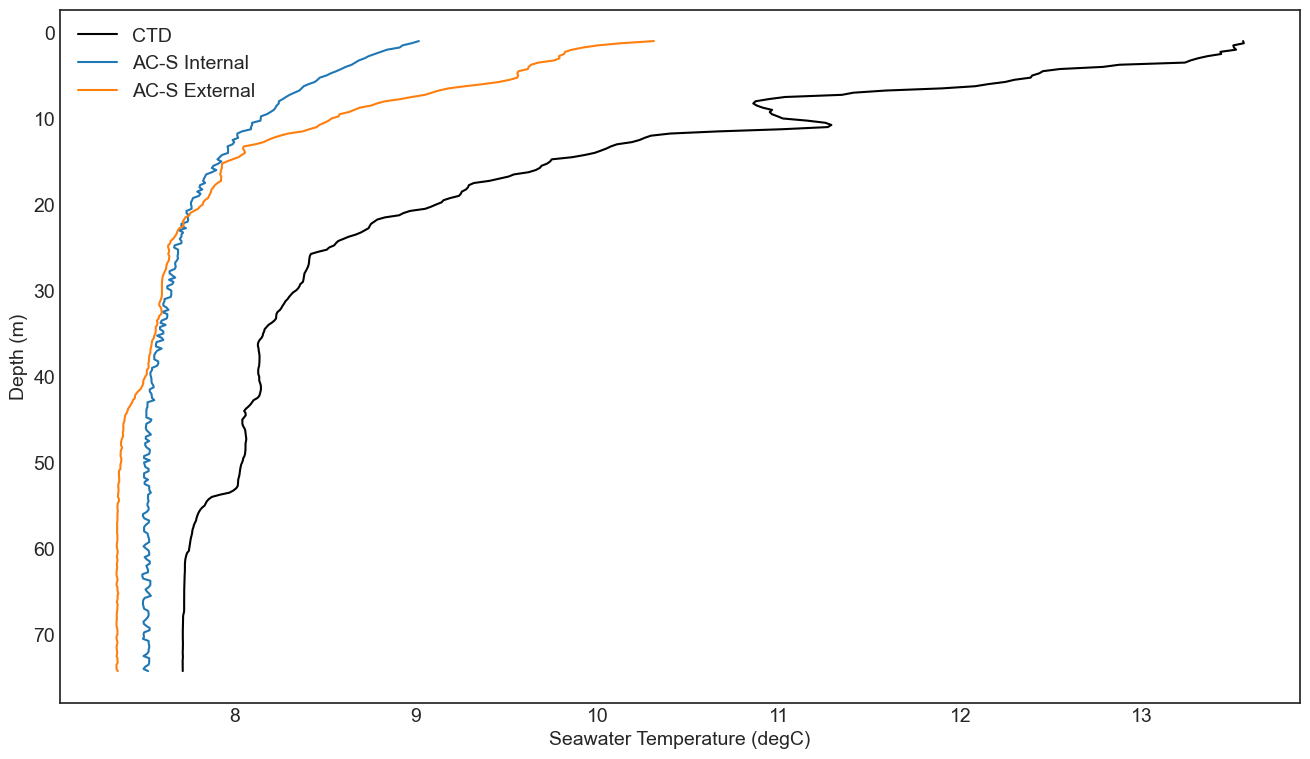

In [8]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 10
profile = profiles[27]
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['ctd_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used in the processing. It is not as accurate as the CTD temperature sensor and it has a slower response rate, so it doesn't accurately represent conditions in the water column. There is still some value to it, just take it with a grain of salt.

That being said, there are a couple of things to note. The internal temperature and the external water temperature (from the CTD) should be close to each other near the start of the profile, diverging as the profiler rises through the water column. Also, the external temperature sensor, with some offset due to differences in accuracy, should approximate the shape of the CTD temperature sensor (taking into account the response rate differences).

The AC-S data can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentration. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors.

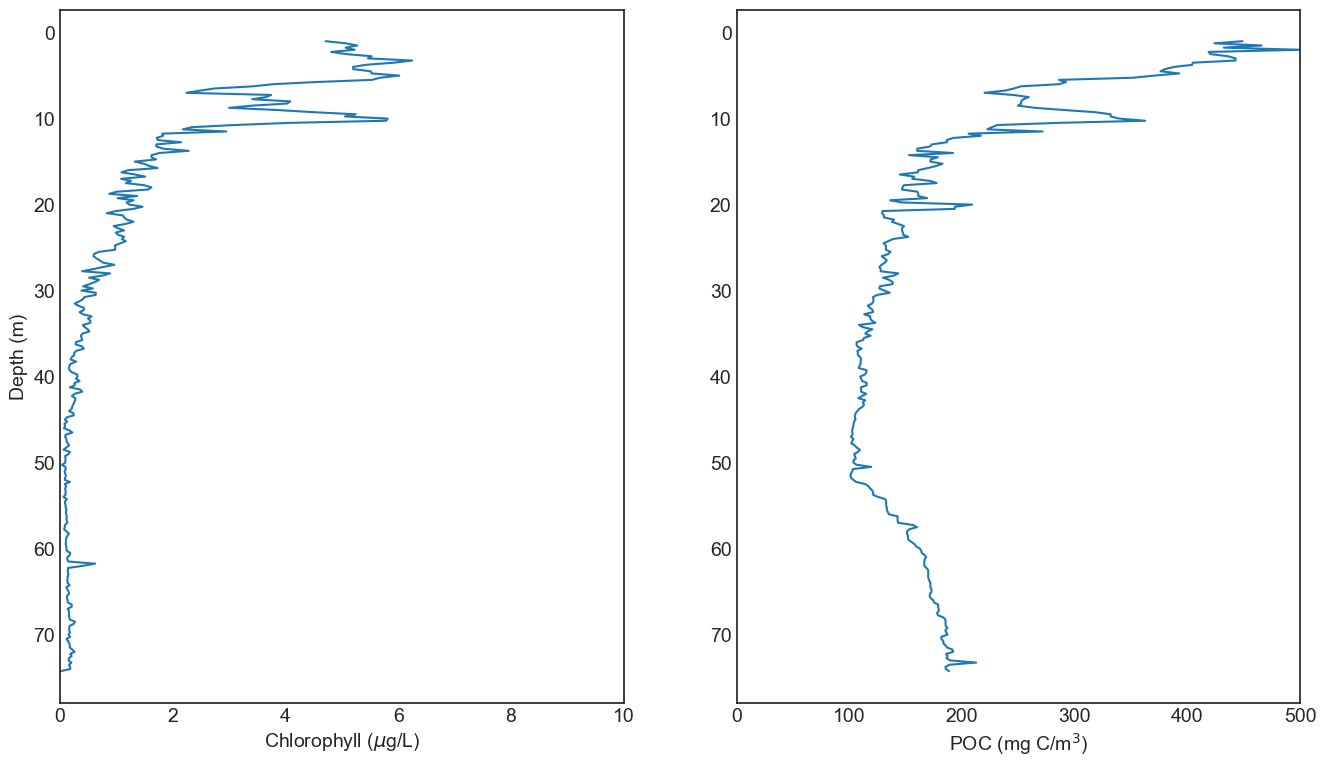

In [9]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'])
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 10])

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.gca().invert_yaxis()
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 500])
plt.show()

Finally, examining the shape and magnitudes of the absorption and attenuation spectra can be helpful in assessing the instrument performance in addition to revealing interesting information about the in situ absorption and attenuation properties of the seawater.

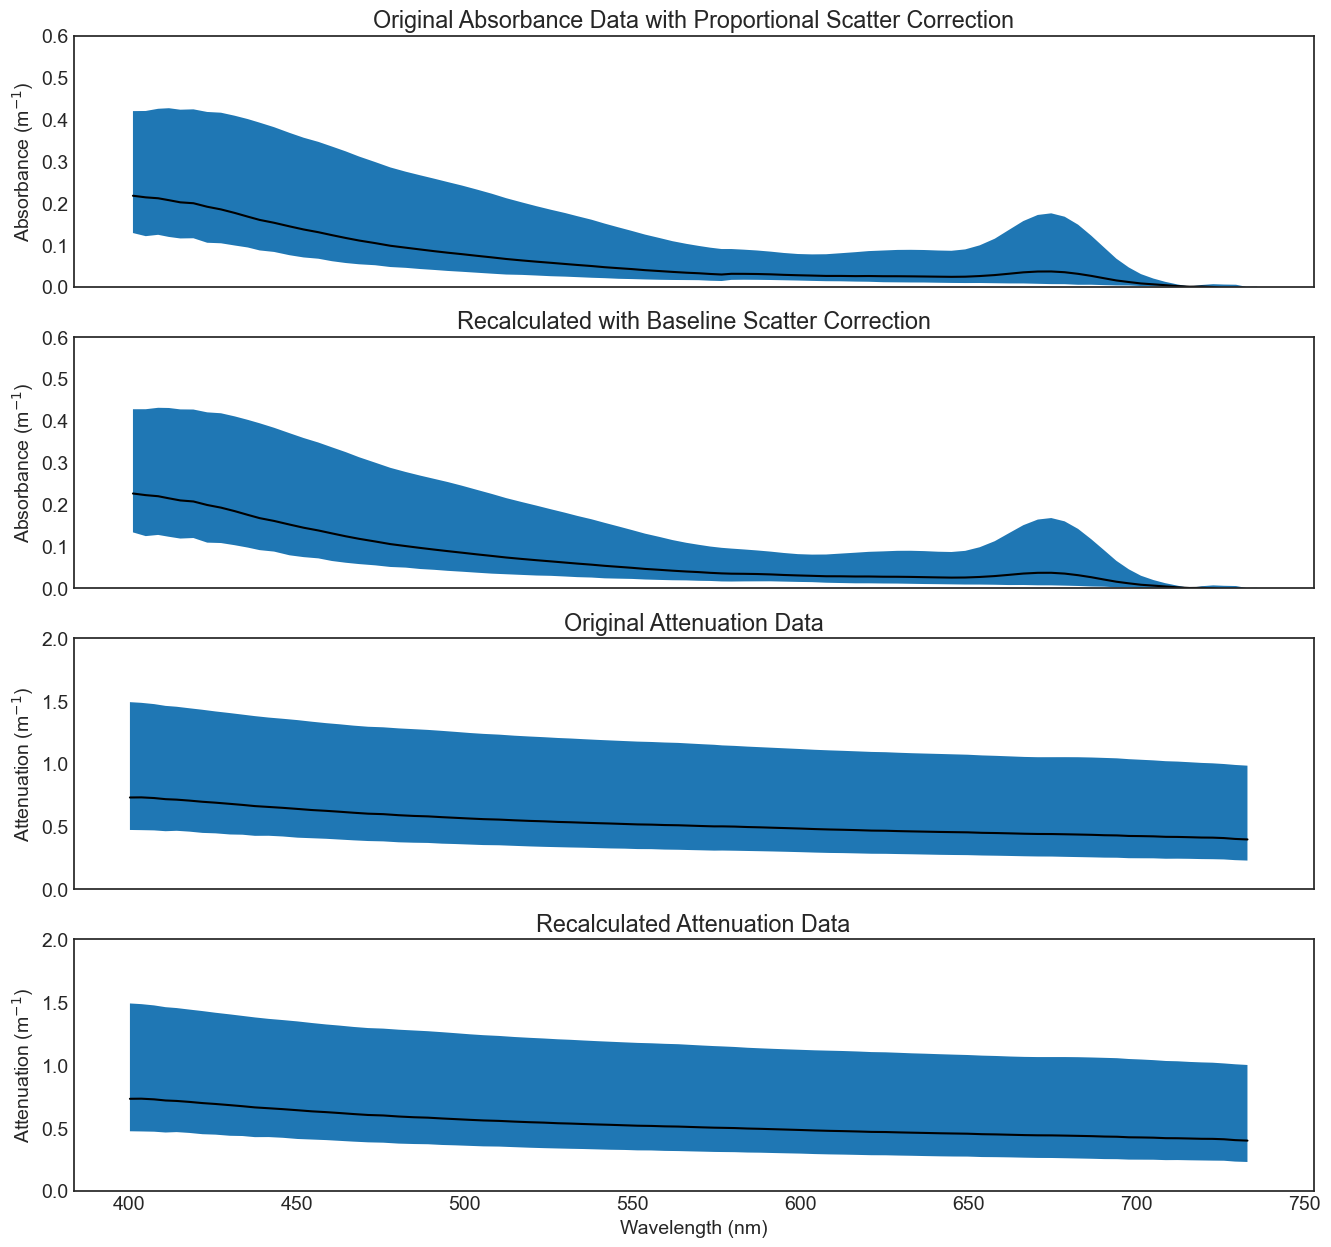

In [10]:
# plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,15))

ax1 = plt.subplot(411)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].mean(axis=0) + profile['optical_absorption'].std(axis=0) * 3)
plt.ylim([0, 0.6])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Original Absorbance Data with Proportional Scatter Correction')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apd_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apd_ts_s'].min(axis=0), 
                 profile['apd_ts_s'].mean(axis=0) + profile['apd_ts_s'].std(axis=0) * 3)
plt.ylim([0, 0.6])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Recalculated with Baseline Scatter Correction')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].mean(axis=0) + profile['beam_attenuation'].std(axis=0) * 3)
plt.ylim([0, 2.0])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.title('Original Attenuation Data')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['cpd_ts'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['cpd_ts'].min(axis=0), 
                 profile['cpd_ts'].mean(axis=0) + profile['cpd_ts'].std(axis=0) * 3)
plt.ylim([0, 2.0])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.title('Recalculated Attenuation Data')

plt.show()

Based on the plots of the chlorophyll, POC and absorbance and attenuation spectra, this particular deployment is looking quite good. Beyond needing to account for the occasional spikes in the data due to particulate matter (a common hazard for bio-optical instruments), the spectra, estimated chlorohyll and POC concentrations all look quite reasonable. There are some different ways to look at the data, either per profile like above, or slicing out a particular depth interval. For example....

In [11]:
# create a slice at 10 m for the entire deployment
final = xr.concat(profiles, 'time')
slice10 = final.where((final['depth'] >= 9.75) & (final['depth'] <= 10.25), drop=True)

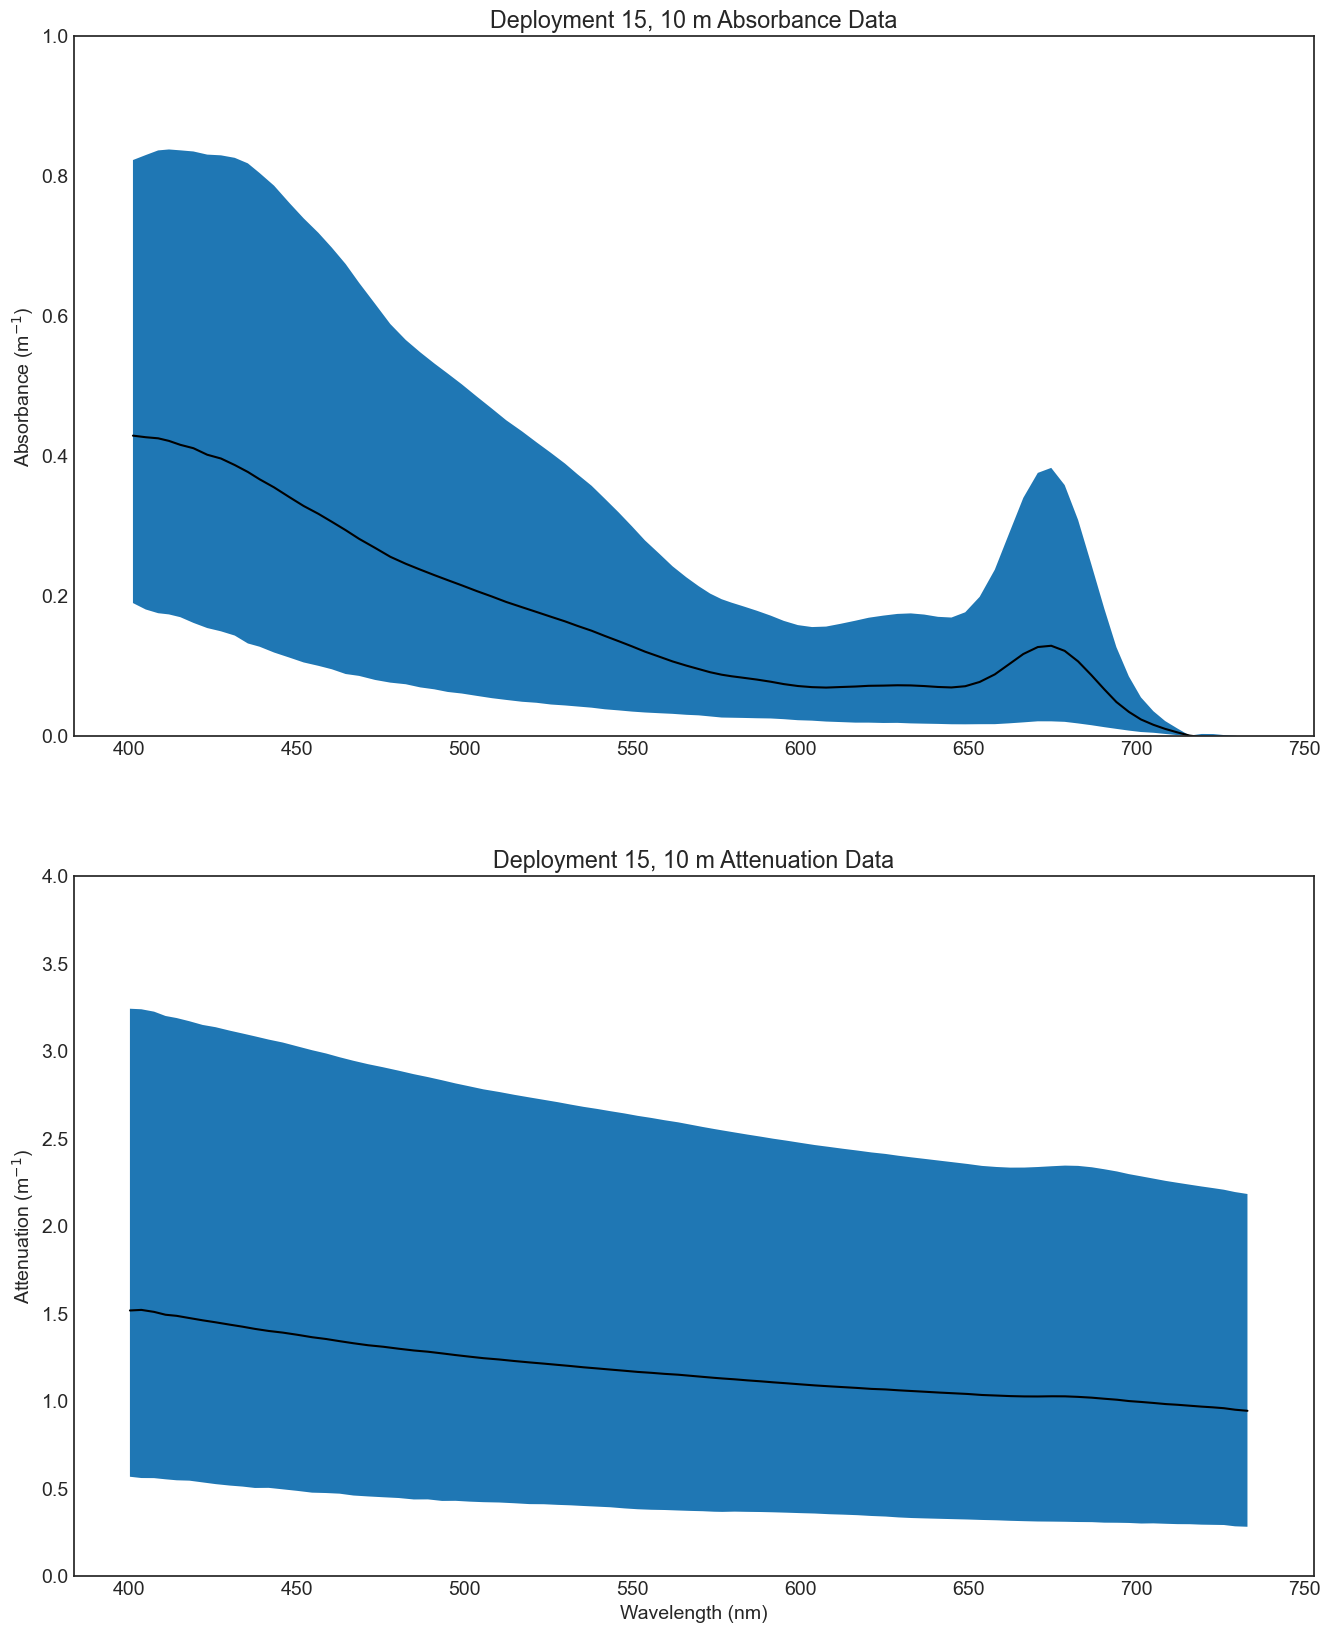

In [12]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(211)
plt.plot(slice10['wavelength_a'][0, :], slice10['apd_ts_s'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_a'][0, :], slice10['apd_ts_s'].min(axis=0), 
                 slice10['apd_ts_s'].mean(axis=0) + (slice10['apd_ts_s'].std(axis=0) * 3))
plt.ylim([0, 1])
plt.title('Deployment 15, 10 m Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(slice10['wavelength_c'][0, :], slice10['cpd_ts'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_c'][0, :], slice10['cpd_ts'].min(axis=0), 
                 slice10['cpd_ts'].mean(axis=0) + (slice10['cpd_ts'].std(axis=0) * 3))
plt.ylim([0, 4])
plt.title('Deployment 15, 10 m Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.show()

In [13]:
# reset some variable level attributes and prepare the data to save to disk
attrs = dict({
    # Derived values in the re-processed data set
    'external_temp': {
        'long_name': 'External Instrument Temperature',
        'standard_name': 'sea_water_temperature',
        'units': 'degrees_Celsius',
        'comment': ('In-situ sea water temperature measurements from the sensor mounted at the top of the '
                    'AC-S pressure housing.'),
        'ancillary_variables': 'external_temp_raw'
    },
    'internal_temp': {
        'long_name': 'Internal Instrument Temperature',
        'units': 'degrees_Celsius',
        'comment': 'Internal instrument temperature, used to convert raw absorbance and attenuation measurements.',
        'ancillary_variables': 'internal_temp_raw'
    },
    'apd': {
        'long_name': 'Particulate and Dissolved Absorbance',
        'units': 'm-1',
        'comment': ('The optical absorption coefficient is the rate that the intensity of a beam of light will '
                    'decrease in response to the absorption (removal) of light energy as a function of '
                    'propagation distance. The optical absorption coefficient reflects the absorption coefficient '
                    'for the combination of all seawater impurities, including all particulate and dissolved '
                    'matter of optical importance.'),
        'data_product_identifier': 'OPTABSN_L1',
        'ancillary_variables': ('wavelength_a internal_temp a_signal_raw a_reference_raw '
                                'a_signal_dark a_reference_dark'),
        '_FillValue': np.nan
    },
    'apd_ts': {
        'long_name': 'Particulate and Dissolved Absorbance with TS Correction',
        'units': 'm-1',
        'comment': ('The optical absorption coefficient corrected for the effects of temperature and salinity. '
                    'Utilizes data from a co-located CTD for the temperaure and salinity corrections, '
                    'if available.'),
        'ancillary_variables': 'wavelength_a ctd_temperature ctd_salinity external_temp apd',
        '_FillValue': np.nan
    },
    'apd_ts_s': {
        'long_name': 'Particulate and Dissolved Absorbance with TS and Scatter Correction',
        'standard_name': 'volume_absorption_coefficient_of_radiative_flux_in_sea_water',
        'units': 'm-1',
        'comment': ('The optical absorption coefficient corrected for scattering after correcting for '
                    'temperature and salinity. Utilizes Method 1 (baseline correction) by subtracting the '
                    'absorption at 715 nm from all values; assumes scattering is flat across wavelengths.'),
        'data_product_identifier': 'OPTABSN_L2',
        'ancillary_variables': 'wavelength_a apd_ts',
        '_FillValue': np.nan
    },
    'cpd': {
        'long_name': 'Particulate and Dissolved Attenuation',
        'units': 'm-1',
        'comment': ('The optical beam attenuation coefficient is the rate that the intensity of a beam of light '
                    'will decrease in response to the combined effects of absorption and scatter as a function of '
                    'propagation distance. The attenuation coefficient results from the spectral beam attenuation '
                    'of the combination of all seawater impurities including all particulate and dissolved matter '
                    'of optical importance.'),
        'data_product_identifier': 'OPTATTN_L1',
        'ancillary_variables': ('wavelength_c internal_temp c_signal_raw c_reference_raw '
                                'c_signal_dark c_reference_dark'),
        '_FillValue': np.nan
    },
    'cpd_ts': {
        'long_name': 'Particulate and Dissolved Attenuation with TS Correction',
        'units': 'm-1',
        'comment': ('The optical beam attenuation coefficient corrected for the effects of temperature and salinity. '
                    'Utilizes data from a co-located CTD for the temperaure and salinity for the temperature '
                    'and salinity corrections, if available.'),
        'data_product_identifier': 'OPTATTN_L2',
        'ancillary_variables': 'wavelength_c ctd_temperature ctd_salinity external_temp cpd',
        '_FillValue': np.nan
    },
    'estimated_chlorophyll': {
        'long_name': 'Estimated Chlorophyll Concentration',
        'standard_name': 'mass_concentration_of_chlorophyll_in_sea_water',
        'units': 'ug L-1',
        'comment': ('Uses the absorption line height at 676 nm, above a linear background between 650 and 715 nm '
                    'with a chlorophyll specific absorption of 0.020 L/ug/m, to estimate the concentration of '
                    'chlorophyll. This method has been shown to be significantly related to extracted chlorophyll '
                    'concentrations and is robust in response to mild to moderate biofouling.'),
        'ancillary_variables': 'apd_ts_s',
        '_FillValue': np.nan
    },
    'estimated_poc': {
        'long_name': 'Estimated POC Concentration',
        'standard_name': 'mass_concentration_of_organic_detritus_expressed_as_carbon_in_sea_water',
        'units': 'ug L-1',
        'comment': ('Uses the particulate beam attenuation coefficient at 660 nm and a coefficient of 380 ug/L/m. '
                    'This calculation is not robust in response to biofouling and is expected to breakdown as '
                    'biofouling begins to dominate the signal.'),
        'ancillary_variables': 'cpd_ts',
        '_FillValue': np.nan
    }
})

for key, value in attrs.items():
    for atk, atv in value.items():
        if key in final.variables:
            final[key].attrs[atk] = atv

# convert all float64 values to float32 (except for the timestamps), helps minimize file size
for v in final.variables:
    if v not in ['time', 'internal_timestamp']:
        if final[v].dtype is np.dtype('float64'):
            final[v] = final[v].astype('float32')
            final[v].attrs['_FillValue'] = np.nan
            
        if final[v].dtype is np.dtype('int32'):
            final[v].attrs['_FillValue'] = -9999999

In [14]:
final

<xarray.Dataset>
Dimensions:                  (wavelength: 100, time: 16479)
Coordinates:
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 95 96 97 98 99
  * time                     (time) datetime64[ns] 2019-08-13T19:04:20.136999...
Data variables: (12/34)
    external_temp_raw        (time) int32 41018 41018 41018 ... 38645 38623
    deployment               (time) int32 15 15 15 15 15 15 ... 15 15 15 15 15
    lat                      (time) float32 44.64 44.64 44.64 ... 44.64 44.64
    ctd_pressure             (time) float32 70.54 70.37 70.08 ... 1.246 1.044
    lon                      (time) float32 -124.3 -124.3 ... -124.3 -124.3
    internal_temp_raw        (time) int32 51377 51377 51371 ... 50621 50606
    ...                       ...
    wavelength_c             (time, wavelength) float32 400.3 403.7 ... nan nan
    c_signal_counts          (time, wavelength) int32 691 814 ... -9999999
    c_reference_counts       (time, wavelength) int32 862 986 ... -9999999
    beam_attenuation         (time, wavelength) float32 0.6718 0.6634 ... nan
    cpd                      (time, wavelength) float32 0.6698 0.6614 ... nan
    cpd_ts                   (time, wavelength) float32 0.6718 0.6634 ... nan
Attributes: (12/67)
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [15]:
final.to_netcdf('ce02shsp.deploy015.optaa.nc', mode='w', format='NETCDF4', engine='h5netcdf')